R environment

In [ ]:
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(Seurat)
    library(dplyr)
    library(tidyr)
    library(purrr)
    library(tibble)
    library(stringr)
    library(dittoSeq)
    library(future)
    library(data.table)
    plan("multiprocess", workers = 8)
    options(future.globals.maxSize = 1000 * 1024^5)
    options(stringsAsFactors = FALSE)
    set.seed(123)
})

In [ ]:
reference <- readRDS('data/coarse_annotation_GBmap.rds')
reference <- subset(reference, idents = 'TIL')
reference <- subset(reference, subset = c(Leiden == '45' | Leiden == '53' ), 
                    invert = TRUE) # exclude plasma and B cells

In [ ]:
use_condaenv("scarches")

In [ ]:
sc <- import("scanpy")
adata <- sc$read_h5ad("data/lymphoid_SCVI_1000hvg.5had")

In [ ]:
# set embeddings
embedding <- adata$obsm["X_umap"]
rownames(embedding) <- colnames(reference) # obs_names from reference_latent does not have cellIDs (only indexes)
colnames(embedding) <- c("umap_1", "umap_2")
reference[["umap2"]] <- CreateDimReducObject(embedding, key = "umap2_")

# set UMAP models
umap.new.model <- list()
umap.new.model$n_epochs <- 500
umap.new.model$alpha <-1
umap.new.model$method <- "umap"
umap.new.model$negative_sample_rate <- 5
umap.new.model$gamma <- 1
umap.new.model$approx_pow <- 0
umap.new.model$metric$cosine <- list()
umap.new.model$embedding <- reference[["umap2"]]@cell.embeddings
ab_param <- uwot:::find_ab_params(spread = 1, min_dist = 0.3)
umap.new.model$a <- ab_param["a"]
umap.new.model$b <- ab_param["b"]
reference[["umap2"]]@misc$model <- umap.new.model

Warning message:
“No assay specified, setting assay as RNA by default.”


In [ ]:
modules <- read.csv('data/lymphoid_modules_hotspot_1000hvg.csv')
modules

Gene           C             Z          Pval       FDR        Module
1    CCL4L2         0.4805915     5198.045   0          0          -1    
2    HBA2           0.2724609     3093.974   0          0          -1    
3    TRDC           0.4746204     2493.504   0          0           2    
4    PLCG2          0.3438264     2470.837   0          0          12    
5    HSP90AA1       0.6884845     2174.607   0          0           8    
6    KRT81          0.5010137     2131.508   0          0           2    
7    HSPH1          0.5860855     2047.555   0          0           8    
8    TNFRSF4        0.4372966     1772.627   0          0           7    
9    HBA1           0.2504886     1758.638   0          0          -1    
10   ISG15          0.6112846     1720.210   0          0           3    
11   MT-ND4L        0.5305852     1575.471   0          0          10    
12   LTB            0.4245191     1540.559   0          0          12    
13   HBB            0.6683816     1499.601   0          0          -1    
14   FCER1G         0.5945339     1494.331   0          0           2    
15   KLRF1          0.4398393     1492.231   0          0           2    
16   MT-ATP6        0.6594865     1491.154   0          0          10    
17   TYROBP         0.6323692     1433.657   0          0           2    
18   ZFP36L2        0.5230126     1390.811   0          0           4    
19   RPS27          0.6211940     1380.261   0          0          12    
20   KLF2           0.3772798     1372.688   0          0          10    
21   IGFBP2         0.2839091     1352.660   0          0           2    
22   CCL4           0.4843639     1308.252   0          0          -1    
23   CCL3           0.3275811     1290.915   0          0          -1    
24   MKI67          0.5703053     1235.642   0          0           1    
25   RRM2           0.4685345     1198.419   0          0           1    
26   NKG7           0.6662742     1167.829   0          0           9    
27   EGR1           0.3801284     1133.411   0          0           5    
28   S100A4         0.5870497     1098.724   0          0          12    
29   MT-ND3         0.6243112     1057.832   0          0          10    
30   CCL5           0.6333242     1055.449   0          0           9    
⋮    ⋮              ⋮             ⋮          ⋮          ⋮          ⋮     
971  CBWD6           0.0293869625  1.3335586 0.09117429 0.09389731 NA    
972  NOPCHAP1        0.0056181355  1.3195711 0.09348912 0.09618223 NA    
973  ZNF350          0.0106292902  1.3034577 0.09620927 0.09887901 NA    
974  VWA5A           0.0285733599  1.2831694 0.09971637 0.10237820 NA    
975  SDHAF4          0.0023331244  1.2596843 0.10389163 0.10655552 NA    
976  BRF2            0.0171763379  1.2392765 0.10762157 0.11026800 NA    
977  H2BC8           0.0121289239  1.2215499 0.11093894 0.11355060 NA    
978  MED7            0.0243690953  1.1773326 0.11953139 0.12222024 NA    
979  FKRP            0.0052342523  1.1605251 0.12291754 0.12555418 NA    
980  CCDC77          0.0017199468  1.1265074 0.12997541 0.13262797 NA    
981  PPP1R3D         0.0112240065  1.1189178 0.13158760 0.13413619 NA    
982  TMEM41A         0.0070446911  1.0818630 0.13965670 0.14221660 NA    
983  ZNF169          0.0224003671  1.0710778 0.14206723 0.14452414 NA    
984  ZNF569          0.0070931758  0.9959872 0.15962818 0.16222376 NA    
985  TBC1D13         0.0018410147  0.9668577 0.16680759 0.16934780 NA    
986  ALKBH3          0.0051717510  0.9526098 0.17039390 0.17281329 NA    
987  MTRF1           0.0050895529  0.9449533 0.17234135 0.17461130 NA    
988  UNK             0.0048340819  0.9408837 0.17338222 0.17548808 NA    
989  ZKSCAN4         0.0183350205  0.9144788 0.18023266 0.18223727 NA    
990  RP11-1017G21.5  0.0007304426  0.8834205 0.18850456 0.19040865 NA    
991  BBS4            0.0074810601  0.8741625 0.19101487 0.19274962 NA    
992  LINC02910       0.0004916558  0.7176652 0.23648188 0.23838899 NA    
993  CNEP

In [ ]:
x <- modules %>% group_by(Module) %>% top_n(n = 50, wt = Z) %>% arrange(Module)
x_split <- split(x, x$Module)
x_split[['-1']] <- NULL
x_split

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom



$`1`
# A tibble: 46 × 6
# Groups:   Module [1]
   Gene      C     Z  Pval   FDR Module
   <chr> <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 MKI67 0.570 1236.     0     0      1
 2 RRM2  0.469 1198.     0     0      1
 3 BIRC5 0.534  796.     0     0      1
 4 CCNB1 0.425  759.     0     0      1
 5 ASPM  0.532  748.     0     0      1
 6 TOP2A 0.584  705.     0     0      1
 7 H4C3  0.420  684.     0     0      1
 8 CCNB2 0.483  666.     0     0      1
 9 TK1   0.432  650.     0     0      1
10 STMN1 0.728  647.     0     0      1
# … with 36 more rows

$`2`
# A tibble: 46 × 6
# Groups:   Module [1]
   Gene       C     Z  Pval   FDR Module
   <chr>  <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 TRDC   0.475 2494.     0     0      2
 2 KRT81  0.501 2132.     0     0      2
 3 FCER1G 0.595 1494.     0     0      2
 4 KLRF1  0.440 1492.     0     0      2
 5 TYROBP 0.632 1434.     0     0      2
 6 IGFBP2 0.284 1353.     0     0      2
 7 XCL2   0.375  957.     0     0      2
 8 CD7    0.400  810.     0     0      2
 9 CD160  0.241  747.     0     0      2
10 GNLY   0.485  653.     0     0      2
# … with 36 more rows

$`3`
# A tibble: 38 × 6
# Groups:   Module [1]
   Gene       C     Z  Pval   FDR Module
   <chr>  <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 ISG15  0.611 1720.     0     0      3
 2 IFI27  0.135  832.     0     0      3
 3 IFI6   0.464  788.     0     0      3
 4 IFIT1  0.446  643.     0     0      3
 5 IFI44L 0.360  619.     0     0      3
 6 IFIT3  0.464  481.     0     0      3
 7 RSAD2  0.336  384.     0     0      3
 8 IFITM3 0.159  335.     0     0      3
 9 MX1    0.484  333.     0     0      3
10 CMPK2  0.246  311.     0     0      3
# … with 28 more rows

$`4`
# A tibble: 50 × 6
# Groups:   Module [1]
   Gene        C     Z  Pval   FDR Module
   <chr>   <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 ZFP36L2 0.523 1391.     0     0      4
 2 JUNB    0.532  919.     0     0      4
 3 JUN     0.312  855.     0     0      4
 4 FOSB    0.368  763.     0     0      4
 5 DUSP2   0.411  745.     0     0      4
 6 BTG1    0.502  671.     0     0      4
 7 TNFSF9  0.240  619.     0     0      4
 8 IL7R    0.470  565.     0     0      4
 9 RGCC    0.293  563.     0     0      4
10 FTH1    0.386  562.     0     0      4
# … with 40 more rows

$`5`
# A tibble: 30 × 6
# Groups:   Module [1]
   Gene        C     Z  Pval   FDR Module
   <chr>   <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 EGR1    0.380 1133.     0     0      5
 2 RHOB    0.326  881.     0     0      5
 3 C1QC    0.336  701.     0     0      5
 4 CXCL8   0.239  567.     0     0      5
 5 CCL3L3  0.200  558.     0     0      5
 6 GFAP    0.169  504.     0     0      5
 7 FABP7   0.228  445.     0     0      5
 8 PTN     0.187  373.     0     0      5
 9 ZFP36L1 0.188  331.     0     0      5
10 IER3    0.157  242.     0     0      5
# … with 20 more rows

$`6`
# A tibble: 30 × 6
# Groups:   Module [1]
   Gene       C     Z  Pval   FDR Module
   <chr>  <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 PTGDS  0.130  911.     0     0      6
 2 IGFBP7 0.302  649.     0     0      6
 3 SPON2  0.324  614.     0     0      6
 4 MYOM2  0.161  566.     0     0      6
 5 S1PR5  0.223  432.     0     0      6
 6 CX3CR1 0.204  392.     0     0      6
 7 FCGR3A 0.351  334.     0     0      6
 8 CMC1   0.247  332.     0     0      6
 9 GZMB   0.351  331.     0     0      6
10 PRSS23 0.165  294.     0     0      6
# … with 20 more rows

$`7`
# A tibble: 42 × 6
# Groups:   Module [1]
   Gene               C     Z  Pval   FDR Module
   <chr>          <dbl> <dbl> <dbl> <dbl>  <dbl>
 1 TNFRSF4        0.437 1773.     0     0      7
 2 FOXP3          0.425  940.     0     0      7
 3 CD177          0.124  828.     0     0      7
 4 AC133644.2     0.267  816.     0     0      7
 5 TNFRSF18       0.543  813.     0     0      7
 6 IL1R2          0.178  398.     0     0      7
 7 AC002331.1     0.137  321.     0     0      7
 8 TBC1D4         0.215  290.     0     0      7
 9 RP11-1399P15.1 0.101  223.     0     0      7
10 TNFRSF9        0.276  191. 

In [ ]:
signatures.list <- list()

for(i in 1:length(x_split)){
  gene.names <- x_split[[i]]$Gene
  signatures.list <- append(signatures.list, list(gene.names))
}

names(signatures.list) <- letters[1:length(x_split)]

signatures.list

$a
 [1] "MKI67"   "RRM2"    "BIRC5"   "CCNB1"   "ASPM"    "TOP2A"   "H4C3"   
 [8] "CCNB2"   "TK1"     "STMN1"   "AURKB"   "PCLAF"   "NUSAP1"  "HMMR"   
[15] "CENPE"   "HMGB2"   "DUT"     "UBE2C"   "CENPF"   "UBE2S"   "CKS1B"  
[22] "TUBA1B"  "H2AX"    "SMC2"    "SMC4"    "TPX2"    "TYMS"    "HMGN2"  
[29] "H1-5"    "PTTG1"   "TUBB"    "CENPM"   "CDKN3"   "HMGA1"   "KIF20B" 
[36] "DLGAP5"  "CKS2"    "CDK1"    "MCM7"    "KPNA2"   "PCNA"    "H2BC4"  
[43] "TUBA1C"  "CDC25B"  "CCNA2"   "HCFC1R1"

$b
 [1] "TRDC"      "KRT81"     "FCER1G"    "KLRF1"     "TYROBP"    "IGFBP2"   
 [7] "XCL2"      "CD7"       "CD160"     "GNLY"      "XCL1"      "KLRD1"    
[13] "KRT86"     "ADGRG3"    "CXXC5"     "NCR3"      "NCAM1"     "GSTP1"    
[19] "SH2D1B"    "MATK"      "LINC00996" "TMIGD2"    "B3GNT7"    "CEBPD"    
[25] "ITGAX"     "FGR"       "KIR2DL4"   "IL2RB"     "CD9"       "SRGAP3"   
[31] "TRGC1"     "LAT2"      "WIPF3"     "CLNK"      "CD63"      "HOPX"     
[37] "TXK"       "CD300A"    "ANTKMT"    "GNPTAB"    "CLIC3"     "KLRC2"    
[43] "MAPK1"     "KLRC1"     "IRF8"      "MCTP2"    

$c
 [1] "ISG15"    "IFI27"    "IFI6"     "IFIT1"    "IFI44L"   "IFIT3"   
 [7] "RSAD2"    "IFITM3"   "MX1"      "CMPK2"    "EPSTI1"   "MX2"     
[13] "IFITM1"   "SAMD9L"   "STAT1"    "PLSCR1"   "IFITM2"   "IFIT2"   
[19] "SAMD9"    "CXCL10"   "GBP1"     "XAF1"     "TNFSF10"  "OASL"    
[25] "GBP5"     "PARP14"   "APOL6"    "HELZ2"    "HERC5"    "C1orf56" 
[31] "IRF1-AS1" "IFIH1"    "CD38"     "CHI3L2"   "NT5C3A"   "SLFN5"   
[37] "MT2A"     "OAS1"    

$d
 [1] "ZFP36L2"  "JUNB"     "JUN"      "FOSB"     "DUSP2"    "BTG1"    
 [7] "TNFSF9"   "IL7R"     "RGCC"     "FTH1"     "SOCS3"    "KLF6"    
[13] "DUSP4"    "ZFP36"    "FOS"      "CREM"     "TSHZ2"    "PIK3R1"  
[19] "NR4A2"    "NR4A3"    "CITED2"   "TCF7"     "SLC2A3"   "ENC1"    
[25] "TNFAIP3"  "NFKBIA"   "FAM177A1" "SOCS1"    "TGFB1"    "IRF1"    
[31] "CH25H"    "NR4A1"    "CCR7"     "AREG"     "SELL"     "CD55"    
[37] "SH2D2A"   "IER2"     "SYTL3"    "CEBPB"    "ATF3"     "GADD45B" 
[43] "S1PR1"    "TSC22D3"  "NFKB1"    "USP36"    "MYC"      "MAFF"    
[49] "TIPARP"   "ZNF331"  

$e
 [1] "EGR1"     "RHOB"     "C1QC"     "CXCL8"    "CCL3L3"   "GFAP"    
 [7] "FABP7"    "PTN"      "ZFP36L1"  "IER3"     "GAP43"    "SERPINE1"
[13] "MIR9-1HG" "ADAM28"   "CRYAB"    "CSPG5"    "CLU"      "NRCAM"   
[19] "MT3"      "EGR2"     "DTNA"     "LILRB1"   "DUSP6"    "ADAMTS1" 
[25] "ID1"      "KLF9"     "IRF2BPL"  "DYNLL2"   "SGK1"     "SLC1A2"  

$f
 [1] "PTGDS"   "IGFBP7"  "SPON2"   "MYOM2"   "S1PR5"   "CX3CR1"  "FCGR3A" 
 [8] "CMC1"    "GZMB"    "PRSS23"  "PLEK"    "EFHD2"   "PLAC8"   "KIR3DL1"
[15] "FGFBP2"  "C1orf21" "KIR2DL3" "ADGRG1"  "RAMP1"   "ZEB2"    "PRF1"   
[22] "TTC38"   "SYNGR1"  "MLC1"    "CXCR2"   "MTSS1"   "NFIL3"   "AKR1C3" 
[29] "PTPN12"  "FEZ1"   

$g
 [1] "TNFRSF4"        "FOXP3"          "CD177"          "AC133644.2"    
 [5] "TNFRSF18"       "IL1R2"          "AC002331.1"     "TBC1D4"        
 [9] "RP11-1399P15.1" "TNFRSF9"        "PIM3"           "LAYN"          
[13] "IKZF2"          "BIRC3"          "ENTPD1"         "ID3"           
[17] "ARID5B"         "SOX4"           "RTKN2"          "BATF"          
[21] "LAIR2"          "PRDM1"          "ZC2HC1A"        "MAF"           
[25] "MAST4"          "GADD45A"        "LTA"            "TIGIT"         
[29] "HPGD"           "PTGIR"          "IL1RL1"         "BEX3"          
[33] "CTSC"           "CTLA4"          "IL2RA"          "MAGEH1"        
[37] "ITM2A"          "PHLDA1"         "GADD45G"        "CUL9"          
[41] "CCNG2"          "UCP2"          

$h
 [1] "HSP90AA1" "HSPH1"    "HSPE1"    "BAG3"     "HSPA1A"   "HSPB1"   
 [7] "HSPA1B"   "HSPA6"    "TRBV14"   "SERPINH1" "TXNIP"    "DNAJB1"  
[13] "HSP90AB1" "HSPD1"    "ERN1"     "SLC4A7"   "TNFSF14"  "FKBP4"   
[19] "CHORDC1"  "ATG2A"    "DNAJC1"   "BCL2L11"  "PPP3CC"   "CDC42EP3"
[25] "ZFAND2A"  "LDLR"     "KIF13B"   "SLC5A3"  

$i
 [1] "NKG7"        "CCL5"        "CTSW"        "

In [ ]:
reference <- AddModuleScore(object = reference,
                                       features =signatures.list,
                                       name = names(signatures.list)
                                      )

Warning message:
“The following features are not present in the object: DUT, CDC25B, HCFC1R1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: GSTP1, SH2D1B, CD63, ANTKMT, MAPK1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: NT5C3A, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: PIK3R1, FAM177A1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: KLF9, IRF2BPL, DYNLL2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MYOM2, KIR3DL1, ADGRG1, TTC38, SYNGR1, PTPN12, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: AC002331.1, RP11-1399P15.1, BEX3, not searching for symbol synonyms”
Warning message:
“The following features are not present in the

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will rep

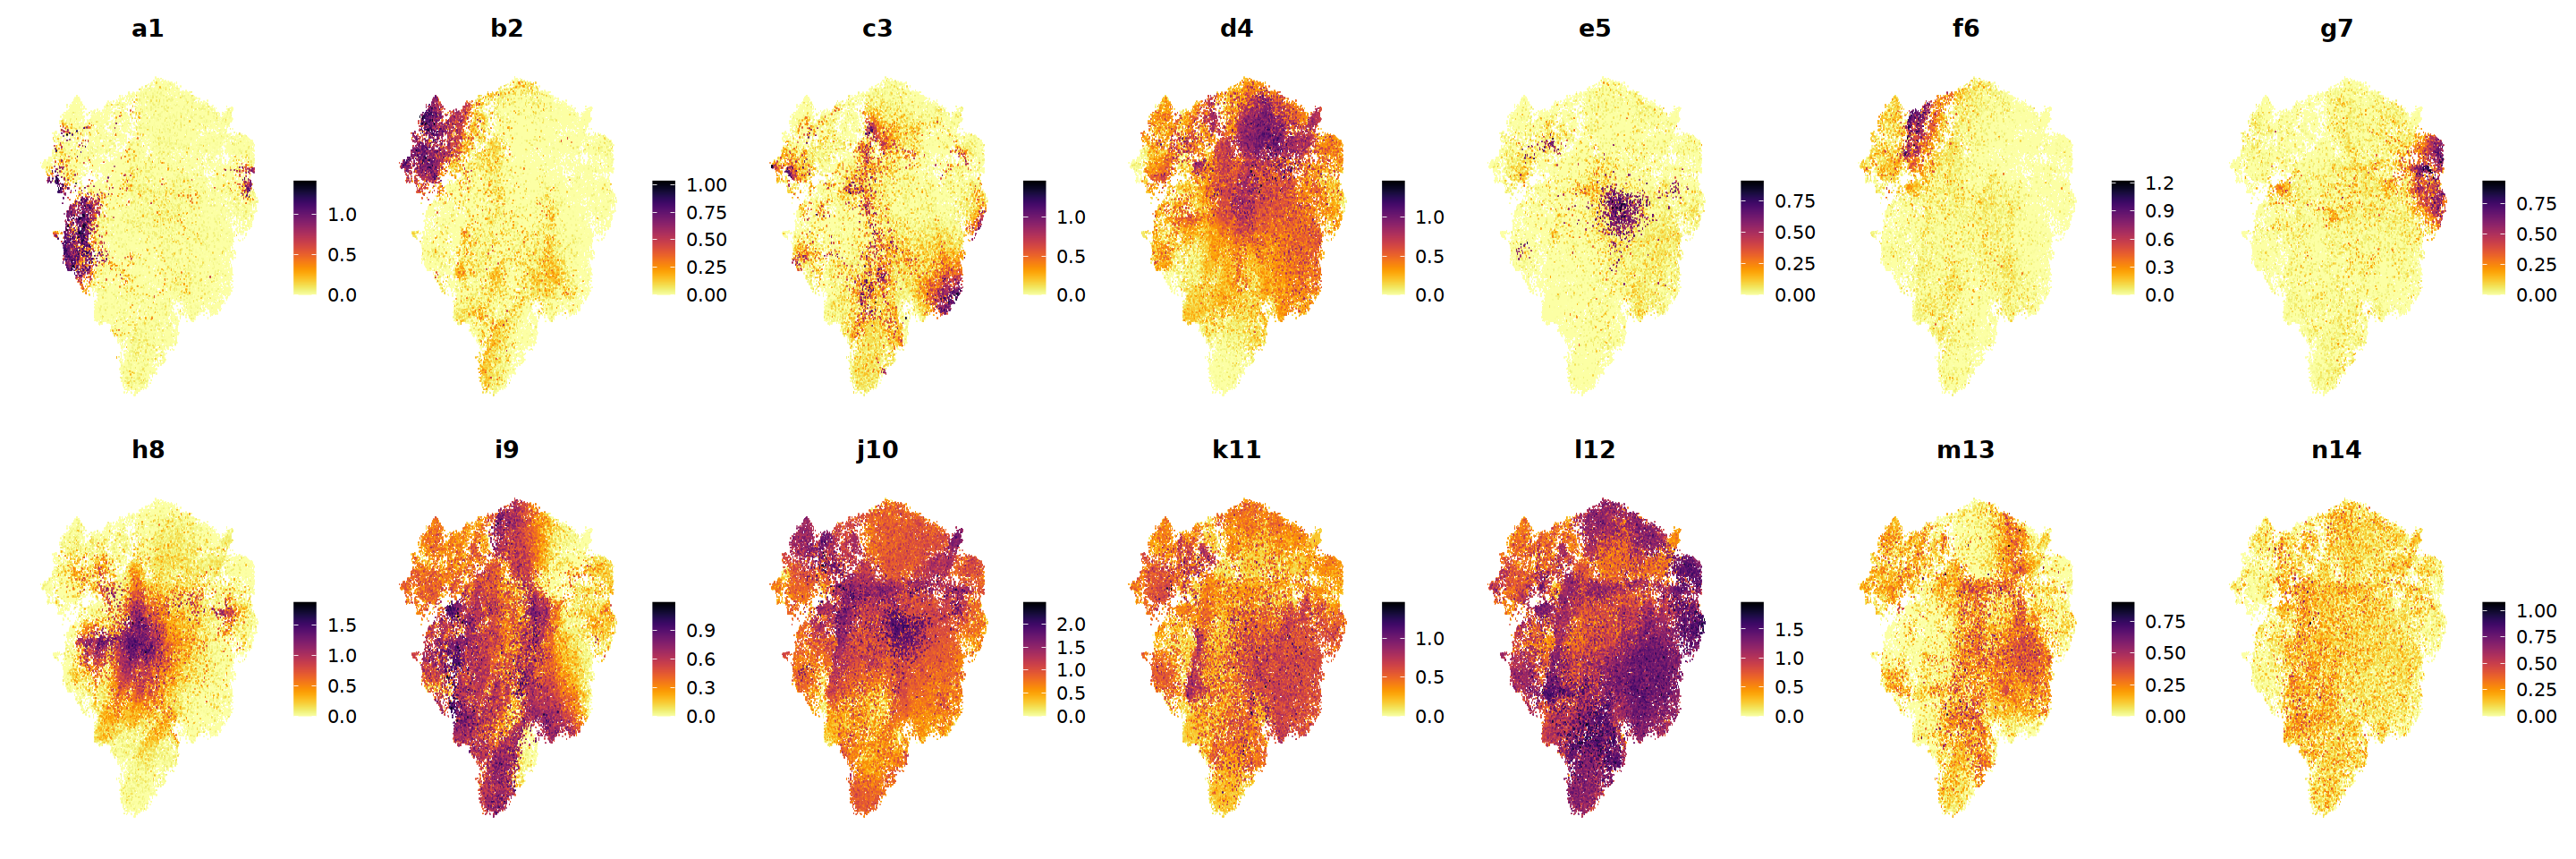

In [ ]:
options(repr.plot.height = 8, repr.plot.width = 24)
p <- FeaturePlot(reference, c('a1','b2','c3','d4','e5','f6','g7','h8','i9','j10','k11','l12','m13','n14'), 
                 reduction = 'umap2', order = TRUE,
                 min.cutoff = 0, pt.size = 1, ncol = 7,
                raster = TRUE) & 
  viridis::scale_colour_viridis(option = 'inferno', direction = -1) 
p & NoAxes() 

# In the manuscript, the number of the modules where arranged in order from top to bottom
# The matching modules dispalyed in Figure 2 and Supp Fig 2 are as follows:
# a1 = Module 1 - Cell cycle
# b2 = Module 3 - NK T cell
# c3 = Module 5 - INF
# d4 = Module 8 - Effector memory
# e5 = Module 7 - Chemotaxis
# f6 = Module 4 - NK CD8+ signature
# g7 = Module 10 - Regulatory T cell
# h8 = Module 9 - Stress signature
# i9 = Module 2 - Cytotoxic
# j10 = Module unspecific (mitochondrial)
# k11 = Module unspecific (immune)
# l12 = Module 6 - T cell identity
# m13 = Module 11 - Polarization
# n14 = Module unspecific

In [ ]:
ggsave('../figures/TIL_module_scores_inferno.pdf', height = 7, width = 25)

For cell annotation, we considered the results from the gene module detection perfomed using Hotspot <br>
and the expression of cell type-specific marker genes identified using the Wilcoxon rank-sum test <br>
by comparing all cells within a specific cluster to all cells outside said cluster. 

In [ ]:
reference <- AddMetaData(reference,
                         adata$obs['leiden_1.5'] %>% `rownames<-` (colnames(reference)))

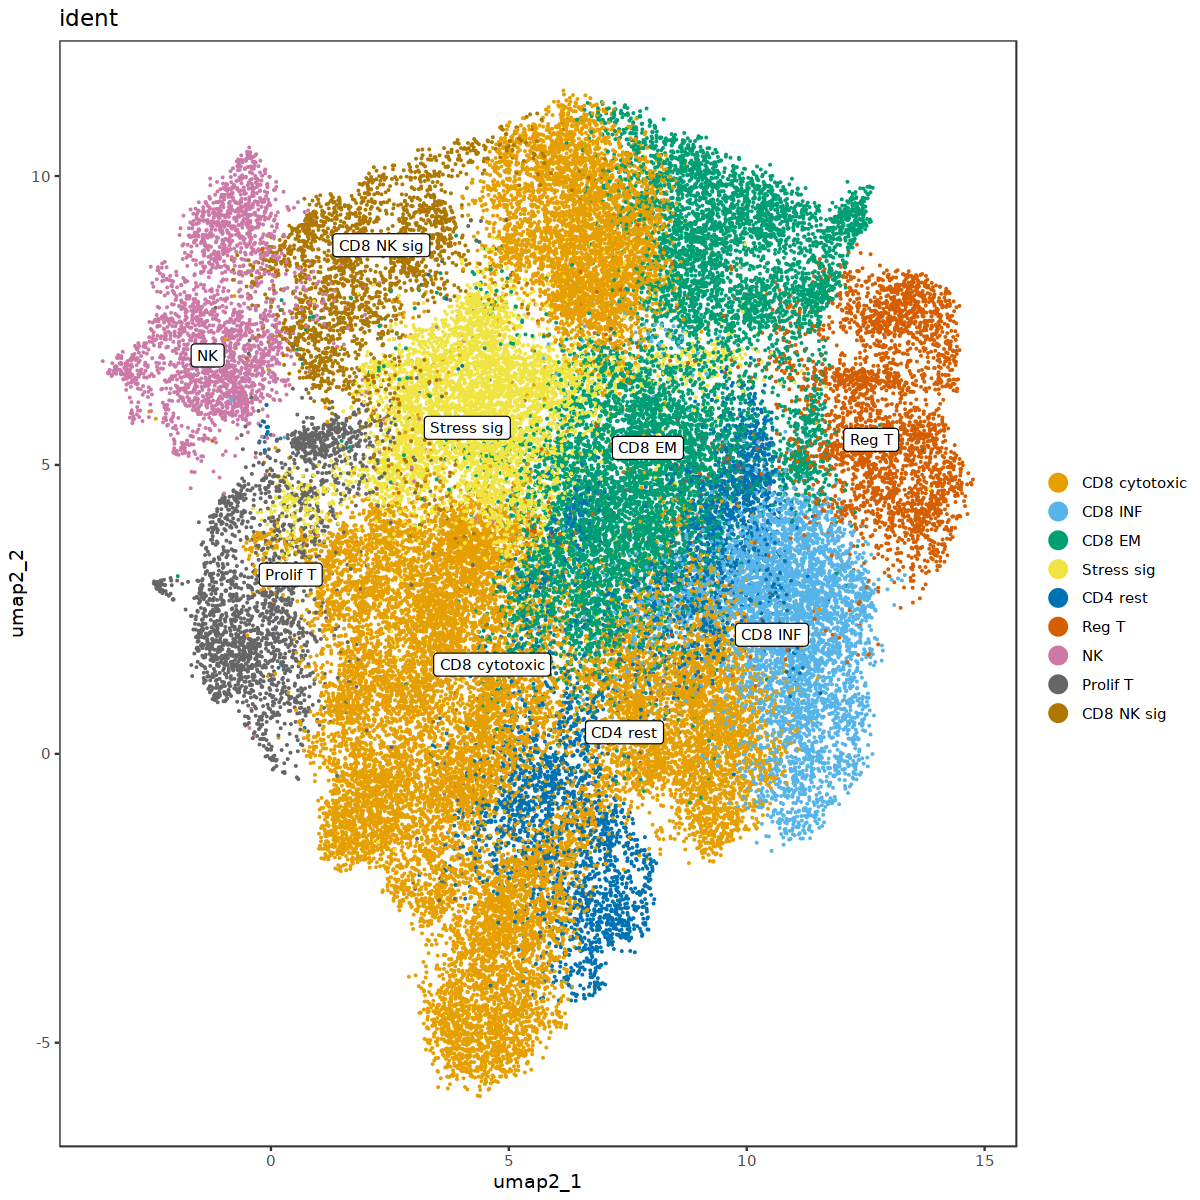

In [ ]:
Idents(reference) <- reference@meta.data$`leiden_1.5`

reference <- RenameIdents(reference, `0` = "CD8 cytotoxic",
                    `1` = "CD8 INF",
                    `2` = "CD8 cytotoxic", 
                    `3` = "CD8 EM", 
                    `4` = "CD8 cytotoxic", 
                    `5` = "Stress sig", 
                    `6` = "CD8 EM", 
                    `7` = "CD8 cytotoxic", 
                    `8` = "CD8 cytotoxic", 
                    `9` = "CD4 rest",
                    `10` = "Reg T",
                    `11` = "NK", 
                    `12` = "CD8 cytotoxic", 
                    `13` = "Prolif T", 
                    `14` = "CD8 NK sig",
                    `15` = "CD4 rest",
                    `16` = "Stress sig", 
                    `17` = "CD8 cytotoxic", 
                    `18` = "CD8 INF", 
                    `19` = "CD8 EM", 
                    `20` = "CD8 cytotoxic", 
                    `21` = "Stress sig", 
                    `22` = "CD8 EM", 
                    `23` = "CD8 EM",
                    `24` = "CD8 EM",
                    `25` = "Reg T", 
                    `26` = "NK", 
                    `27` = "CD8 cytotoxic", 
                    `28` = "CD8 NK sig",
                    `29` = "CD8 cytotoxic",
                    `30` = "CD8 cytotoxic",
                    `31` = "CD8 cytotoxic",
                    `32` = "Prolif T", 
                    `33` = "CD8 EM", 
                    `34` = "Prolif T", 
                    `35` = "CD4 rest",
                    `36` = "CD4 rest"
                        )

options(repr.plot.height = 10, repr.plot.width = 10)
dittoDimPlot(reference, 
             reduction.use = "umap2", var = "ident", 
             do.label = TRUE, labels.size = 3, size = 0.5)

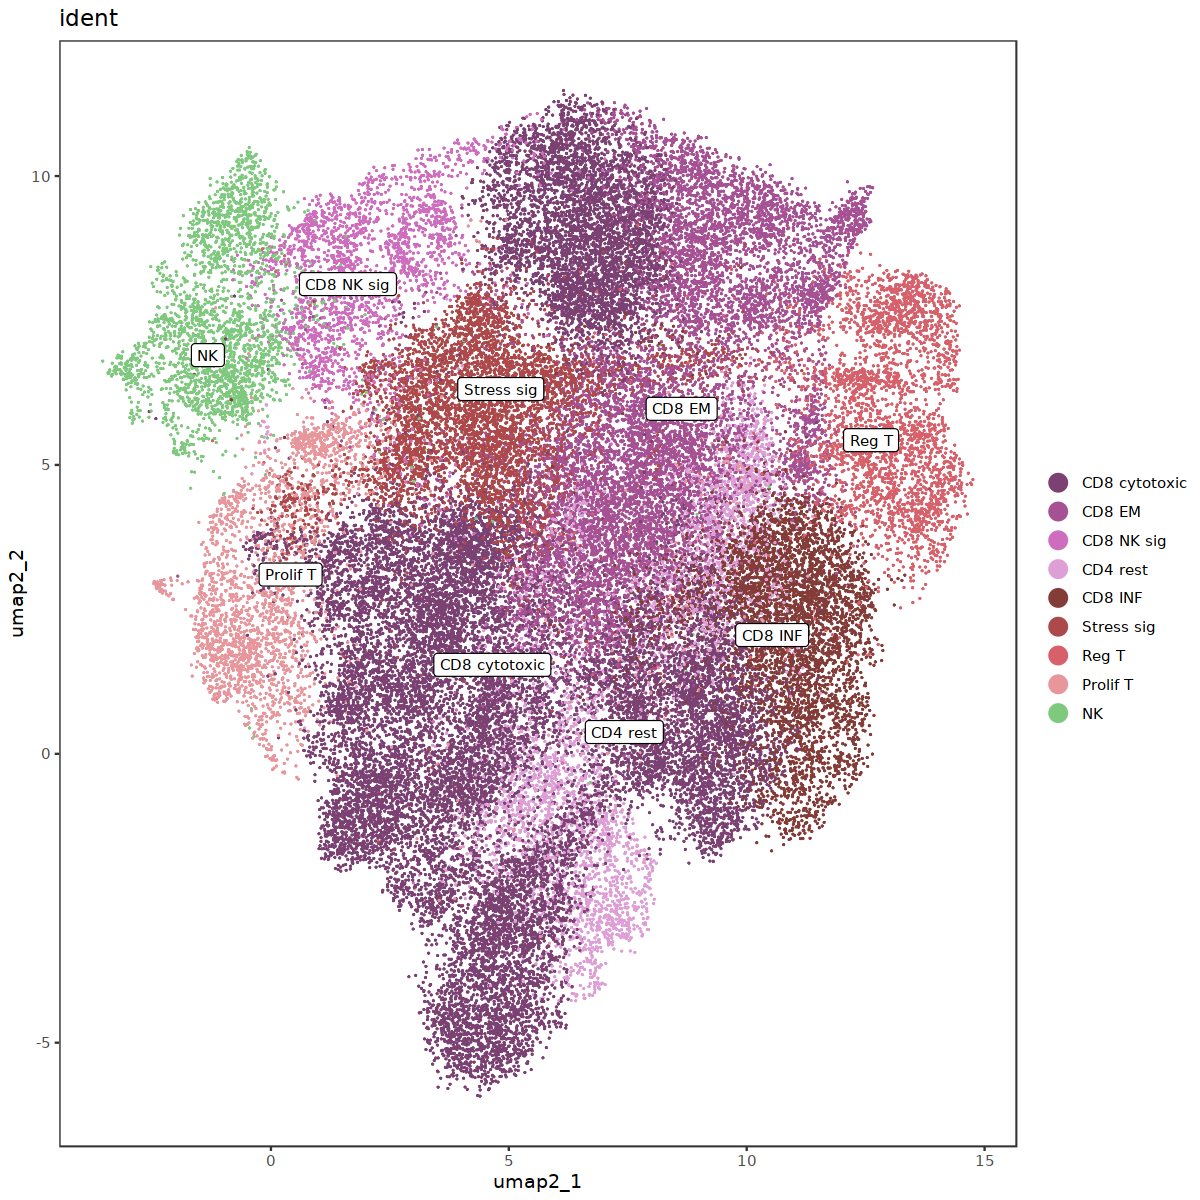

In [ ]:
reference@active.ident <- factor(x = reference@active.ident, 
                                   levels = c('CD8 cytotoxic','CD8 EM', 'CD8 NK sig','CD4 rest', 
                                              'CD8 INF','Stress sig','Reg T','Prolif T','NK'))

options(repr.plot.height = 10, repr.plot.width = 10)
dittoDimPlot(reference, 
             reduction.use = "umap2", var = "ident", 
             color.panel = c('#7b4173','#a55194','#ce6dbd', '#de9ed6',
                             '#843c39','#ad494a','#d6616b','#e7969c', #TIL
                    '#7fc97f'
                            ),
             do.raster = TRUE,
             do.label = TRUE, labels.size = 3, size = 0.5)

In [ ]:
ggsave('../figures/subclustering_TILs.pdf', width = 8)

Saving 8 x 6.67 in image



In [ ]:
saveRDS(Idents(reference), 'data/TILs_detailed_cellstates.rds')